In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import trompy as tp

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

In [11]:
with open(DATAFOLDER / "behav_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_vel"]
#snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]
snips_still = data["snips_still"]

with open(DATAFOLDER / "sigmoidal_fits.pickle", "rb") as f:
    fits = dill.load(f)

fits_df_cluster_raw = fits["fits_df_cluster_raw"]
fits_df_clusterness = fits["fits_df_clusterness"]
fits_df_euclidean = fits["fits_df_euclidean"]

In [12]:
fits_df_cluster_raw

,id,A,L,x0_norm,x0_orig,k,model,success,note
0,PB26,0.024489,0.923220,-0.095859,22.644345,-10.000000,logistic4,True,
2,PB30,0.083253,1.030909,-0.842827,12.080631,-10.000000,logistic4,True,
3,PB31,-0.027289,0.986766,-0.035364,23.499883,-4.822829,logistic4,True,
4,PB46,0.065452,0.649679,-0.304863,19.688587,-10.000000,logistic4,True,
6,PB71,0.048542,0.949934,-0.742174,13.504078,-10.000000,logistic4,True,
7,PB72,0.068427,1.040850,-0.885365,11.479045,-10.000000,logistic4,True,
8,PB73,-0.012700,0.979151,-0.475981,17.268613,-10.000000,logistic4,True,
9,PB75,-0.100000,0.622672,0.146080,26.065886,-1.528708,logistic4,True,


In [ ]:
fits_df_cluster_raw.query("")

PB26 (49, 200)
0.5566867798247833
PB27 (49, 200)
2.9536906230916125
PB30 (49, 200)
0.5641876555880366
PB31 (49, 200)
2.8707337752252635
PB46 (49, 200)
0.835000417200265
PB48 (49, 200)
1.1866443549136196
PB71 (49, 200)
0.8054402553572606
PB72 (49, 200)
1.044794382209872
PB73 (49, 200)
3.60881202941534
PB75 (49, 200)
0.4506919907945247


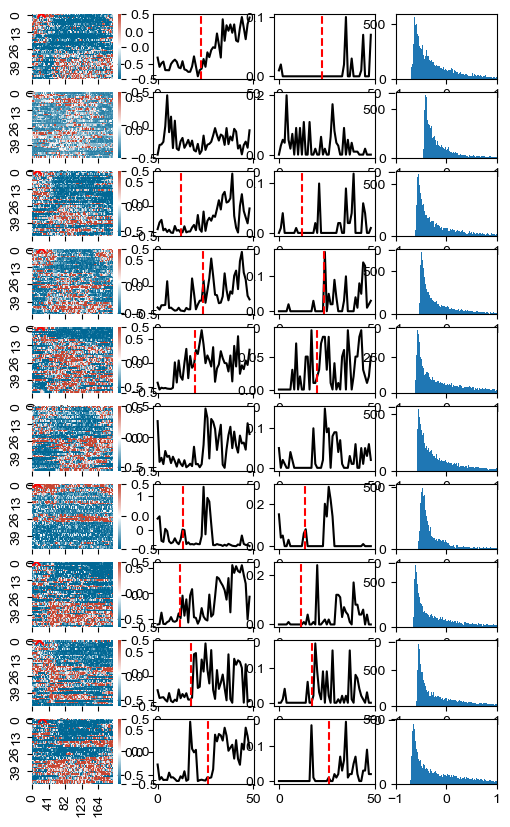

In [ ]:
def get_time_moving(snips, threshold=1):

    moving = []
    for i in range(snips.shape[0]):
        snip = snips[i, 50:150]
        tmp = len([x for x in snip if x > threshold]) / len(snip)
        moving.append(tmp)

    return np.array(moving)

query_string = "condition == 'deplete' & infusiontype == '45NaCl'"

rats = x_array.query(query_string).id.unique()

f, ax = plt.subplots(nrows=len(rats), ncols=4, figsize=(6, len(rats)))

for i, rat in enumerate(rats):
    query_string = f"condition == 'deplete' & infusiontype == '45NaCl' & id == '{rat}'"
    snips_tmp = snips_still[x_array.query(query_string).index]
    print(rat, snips_tmp.shape)
    
    sns.heatmap(snips_tmp,
                vmin=-0.5,
                vmax=0.5,
                ax=ax[i, 0],
                cmap=custom_cmap,)
    
    ax[i, 1].plot(np.nanmedian(snips_tmp[:,50:150], axis=1), color='k')

    # threshold from individual rats
    thr = otsu_threshold(snips_tmp.flatten())
    print(thr)

    # threshold from all rats
    # thr = otsu_threshold(snips_still.flatten())

    

    ax[i, 2].plot(get_time_moving(snips_tmp, threshold=thr_knee), color='k')

    try:
        transition_point = fits_df_cluster_raw.query("id == @rat").x0_orig.values[0]
        ax[i, 0].scatter(transition_point, -0.6, color='r', marker='x')
        ax[i, 1].axvline(transition_point, color='r', linestyle='--')
        ax[i, 2].axvline(transition_point, color='r', linestyle='--')
    except:
        pass


    ax[i, 3].hist(snips_tmp.flatten(), bins=1000)
    ax[i, 3].set_xlim([-1, 1])

In [21]:
import numpy as np

def otsu_threshold(values, nbins=256):
    x = np.asarray(values).ravel()
    x = x[np.isfinite(x)]
    hist, bin_edges = np.histogram(x, bins=nbins)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    weight1 = np.cumsum(hist).astype(float)
    weight2 = weight1[-1] - weight1
    mean1 = np.cumsum(hist * bin_centers) / np.maximum(weight1, 1)
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / np.maximum(weight2[::-1], 1))[::-1]
    # Between-class variance:
    var_between = weight1[:-1] * weight2[:-1] * (mean1[:-1] - mean2[:-1])**2
    idx = np.nanargmax(var_between)
    return float(bin_centers[:-1][idx])

# Example:
thr = otsu_threshold(snips_still.flatten())

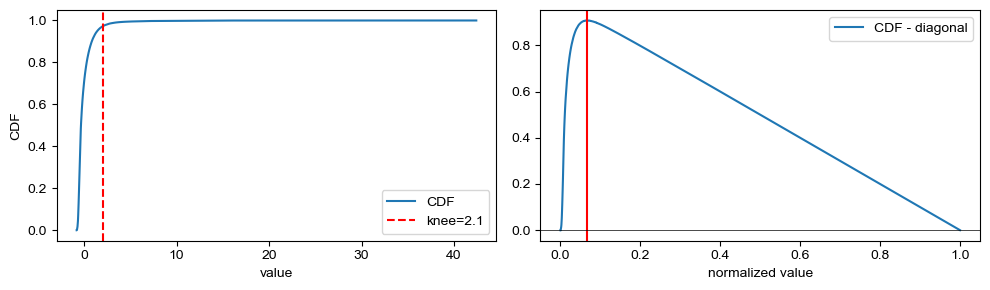

In [27]:
def knee_cdf_threshold(values, frac_clip=0.01, plot=False):
    """Detect a knee (elbow) on the empirical CDF of `values` and return
    a threshold in the original units.

    This implementation normalizes the sorted values to [0,1], computes the
    empirical CDF, then finds the point of maximum deviation from the diagonal
    (y - x_norm). Edges are clipped by `frac_clip` to avoid endpoint artifacts.

    Parameters:
    - values: 1D array-like of numeric values.
    - frac_clip: fraction of data to ignore at each end when searching for the
                 knee (default 0.01).
    - plot: if True, show diagnostic plots (CDF and deviation).

    Returns:
    - threshold (float): value from `values` at detected knee (NaN if empty).
    """
    import numpy as np
    x = np.asarray(values).ravel()
    x = x[np.isfinite(x)]
    if x.size == 0:
        return float('nan')
    x_sorted = np.sort(x)
    n = x_sorted.size
    y = np.arange(1, n+1) / n  # empirical CDF
    # normalize x to [0,1] (avoid zero division)
    denom = (x_sorted.max() - x_sorted.min()) + 1e-12
    x_norm = (x_sorted - x_sorted.min()) / denom
    # vertical deviation from diagonal y=x_norm
    diff = y - x_norm
    # clip edges to avoid endpoint effects
    start = int(np.floor(frac_clip * n))
    end = int(np.ceil((1 - frac_clip) * n))
    if end <= start:
        start = 0
        end = n
    idx = int(np.argmax(diff[start:end]) + start)
    thr = float(x_sorted[idx])
    if plot:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(x_sorted, y, label='CDF')
        axes[0].axvline(thr, color='r', linestyle='--', label=f'knee={thr:.3g}')
        axes[0].set_xlabel('value')
        axes[0].set_ylabel('CDF')
        axes[0].legend()
        axes[1].plot(x_norm, diff, label='CDF - diagonal')
        axes[1].axvline(x_norm[idx], color='r')
        axes[1].axhline(0, color='k', linewidth=0.5)
        axes[1].set_xlabel('normalized value')
        axes[1].legend()
        plt.tight_layout()
    return thr

# Example usage:
thr_knee = knee_cdf_threshold(snips_still.flatten(), plot=True)
# moving_mask = snips_still > thr_knee

In [28]:
print(thr_knee)

2.103942426443434
